In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
def subset_gd_to_df(gdfile):
    '''Returns dataframe with info from annotated.gd, namely frequency, gene product, 
    reject reasons, prediction mode, and polymorphism frequencies'''
    df = pd.read_table(gdfile, comment='#', names=range(50), dtype=str) 
    # https://stackoverflow.com/questions/27700591/reading-csv-files-with-messy-structure-with-pandas
    df.rename(columns = {0: 'entry_type', 1: 'entry_id', 2: 'evidence_id', 
                         3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    for row in df.index:
        #check each column
        col_index = 6
        while col_index < 50:
            #1. mutation frequencies
            if re.match('frequency=', str(df.loc[row, col_index])):
                df.loc[row, 'frequency'] = re.sub('frequency=', '', str(df.loc[row, col_index]))
                if df.loc[row, 'frequency'] == 'NA':
                    df.loc[row, 'frequency'] = np.nan
            #2. gene products
            elif re.match('gene_product=', str(df.loc[row, col_index])):
                df.loc[row, 'gene_product'] = re.sub('gene_product=', '', str(df.loc[row, col_index]))
            #3. polymorphism rejection reasons
            elif re.match('reject=', str(df.loc[row, col_index])):
                df.loc[row, 'reject'] = re.sub('reject=', '', str(df.loc[row, col_index]))
            #4. prediction type
            elif re.match('prediction=', str(df.loc[row, col_index])):
                df.loc[row, 'prediction'] = re.sub('prediction=', '', str(df.loc[row, col_index]))
            #5. polymorphism mode frequencies
            elif re.match('polymorphism_frequency=', str(df.loc[row, col_index])):
                df.loc[row, 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df.loc[row, col_index]))
                if df.loc[row, 'polymorphism_frequency'] == 'NA':
                    df.loc[row, 'polymorphism_frequency'] = np.nan
            col_index += 1
                #set reject col to 'NA' when no reject reason given.
        if 'reject' in df.columns:
            if (df.loc[row, 'reject'] == '') & (df.loc[row, 'evidence_id'] == '.'):
                df.loc[row, 'reject'] = np.nan
        else:
            df['reject'] = np.nan
    #set frequencies type to float
    df[['frequency', 'polymorphism_frequency']] = df[['frequency', 'polymorphism_frequency']].astype(float)
    df_subset = df[['entry_type', 'entry_id', 'evidence_id', 'genome_id', 'position', 'mutation_detail', 
                    'frequency', 'gene_product', 'reject', 'prediction', 'polymorphism_frequency']].copy()
    return df_subset

def subset_mutation_rows(df):
    df_mutations = df[(df['entry_type'] == 'INS') | 
                      (df['entry_type'] == 'DEL') | 
                      (df['entry_type'] == 'SNP') | 
                      (df['entry_type'] == 'SUB') | 
                      (df['entry_type'] == 'MOB') | 
                      (df['entry_type'] == 'AMP') | 
                      (df['entry_type'] == 'CON') | 
                      (df['entry_type'] == 'INV')]
    return df_mutations

def add_evidence_info_to_mutation_rows(df):
    df_mutations = subset_mutation_rows(df)
    df['evidence'] = ''
    for evidence in df_mutations['evidence_id']:
        multi_evidence = evidence.split(',')
        count = 0
        while count < len(multi_evidence):
            entry_row_index = df_mutations[df_mutations['evidence_id'] == evidence].index[0]
            evidence_row_index = df[df['entry_id'] == multi_evidence[count]].index[0]
            df.loc[entry_row_index, 'prediction'] = df.loc[evidence_row_index, 'prediction']
            df.loc[entry_row_index, 'polymorphism_frequency'] = df.loc[evidence_row_index, 'polymorphism_frequency']
            df.loc[entry_row_index, 'evidence'] = df.loc[entry_row_index, 'evidence'] + df.loc[evidence_row_index, 'entry_type']
            count += 1
    return df

def get_mutations_df(gdfile, culture_name, generation=np.nan):
    gd_subset = subset_gd_to_df(gdfile)
    gd_subset_df = add_evidence_info_to_mutation_rows(gd_subset)
    gd_subset_df.insert(0, 'culture', culture_name)
    gd_subset_df.insert(1, 'generation', generation)
    mutations_df = subset_mutation_rows(gd_subset_df).copy()
    return mutations_df

def get_population_subset_frequencies_to_plot(population_df, subset_df):
    merged = pd.merge(population_df, subset_df, on=('genome_id', 'position'))
    population_frequencies_df = merged.drop(['culture_y', 'generation_y', 'entry_type_y', 'entry_id_y', 'evidence_id_y', 
                                          'mutation_detail_y', 'frequency_y', 'gene_product_y', 'reject_y', 
                                          'prediction_y', 'polymorphism_frequency_y'], axis=1)
    reshaped = population_frequencies_df.pivot_table(index=['genome_id', 'position', 'entry_type_x', 'mutation_detail_x'], 
                                                     columns='generation_x', 
                                                     values='polymorphism_frequency_x').fillna(0).T
    return reshaped

In [3]:
# Mutations from clonal isolates

s7 = get_mutations_df('/Users/ymseah/Documents/stahl_lab_ngs_analyses/sic_00_S7_breseq/output/evidence/annotated.gd', 'S7')
s54 = get_mutations_df('/Users/ymseah/Documents/stahl_lab_ngs_analyses/sic_10_S54_breseq/annotated.gd', 'S54')
s55 = get_mutations_df('/Users/ymseah/Documents/stahl_lab_ngs_analyses/sic_11_S55_breseq/annotated.gd', 'S55')
s56 = get_mutations_df('/Users/ymseah/Documents/stahl_lab_ngs_analyses/sic_12_S56_breseq/annotated.gd', 'S56')

In [4]:
# Mutations from population

anc = get_mutations_df('/Users/ymseah/Documents/sic_Ancestor_breseq/annotated.gd', 'UA3', 0)
ua3_100 = get_mutations_df('/Users/ymseah/Documents/sic_UA3-15_breseq/annotated.gd', 'UA3', 100)
ua3_300 = get_mutations_df('/Users/ymseah/Documents/sic_UA3.45_breseq/annotated.gd', 'UA3', 300)
ua3_500 = get_mutations_df('/Users/ymseah/Documents/sic_UA3-76_breseq/annotated.gd', 'UA3', 500)
ua3_780 = get_mutations_df('/Users/ymseah/Documents/sic_UA3.118_breseq/annotated.gd', 'UA3', 780)
ua3_1000 = get_mutations_df('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/evidence/annotated.gd', 'UA3', 1000)

In [5]:
ua3 = pd.concat([anc, ua3_100, ua3_300, ua3_500, ua3_780, ua3_1000])

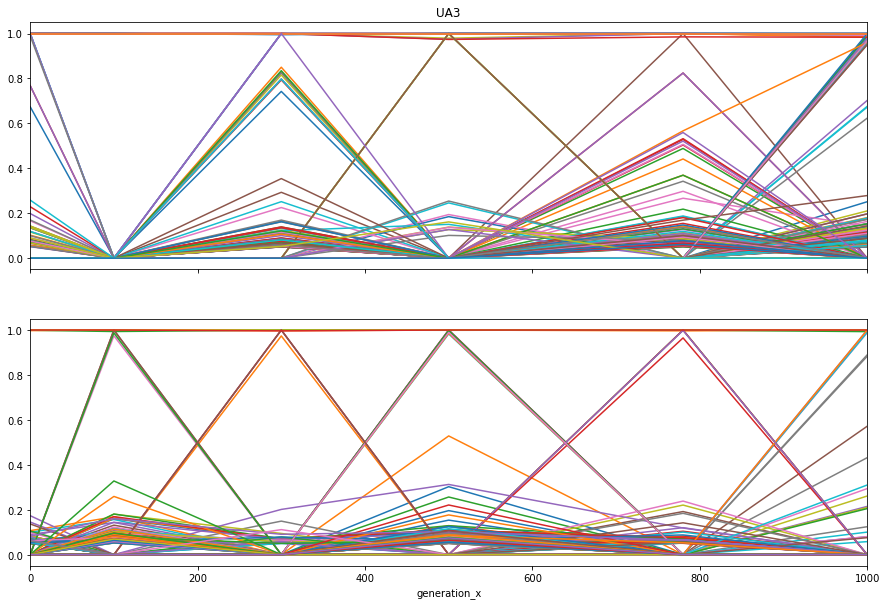

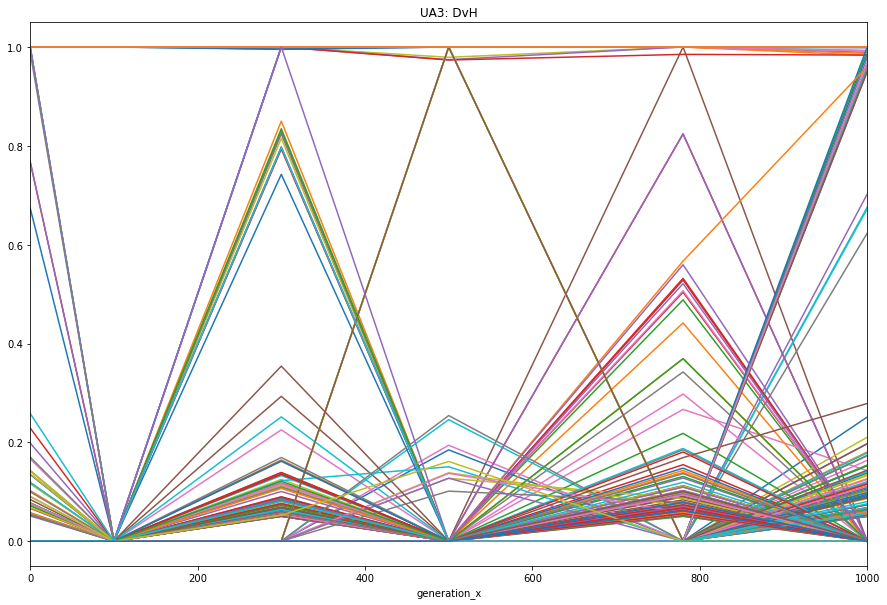

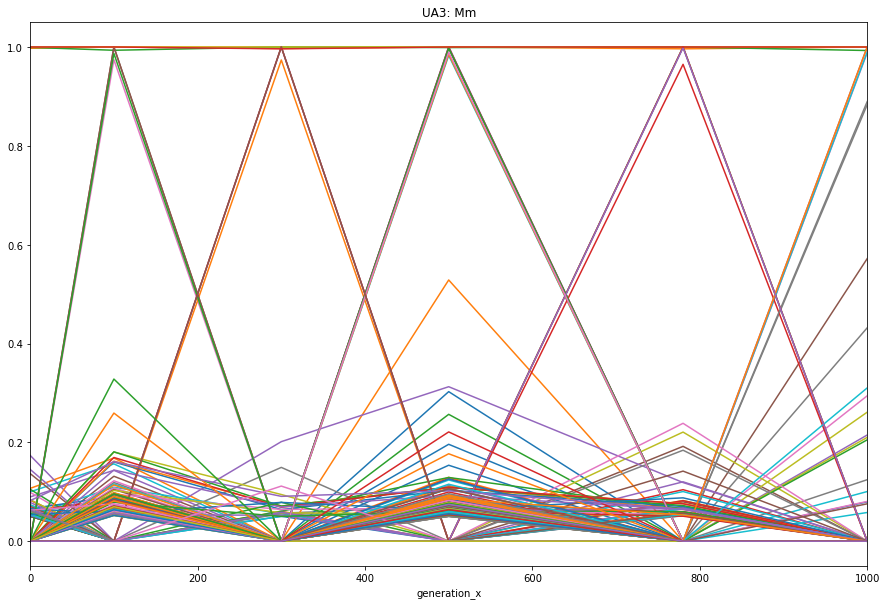

In [6]:
%matplotlib inline

ua3_mutations = get_population_subset_frequencies_to_plot(ua3, ua3)

#Figures produced for lab meeting presentation on 11/1/2017

fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(15,10))
ua3_mutations['NC_002937'].plot(ax = axes[0], legend=False, title = 'UA3') #dvh
ua3_mutations['NC_005791'].plot(ax = axes[1], legend=False) #mm
plt.savefig('ua3_dvh_mm.png')

ua3_mutations['NC_002937'].plot(legend=False, title = 'UA3: DvH', figsize=(15,10))
plt.savefig('ua3_dvh.png')

ua3_mutations['NC_005791'].plot(legend=False, title = 'UA3: Mm', figsize=(15,10))
plt.savefig('ua3_mm.png')

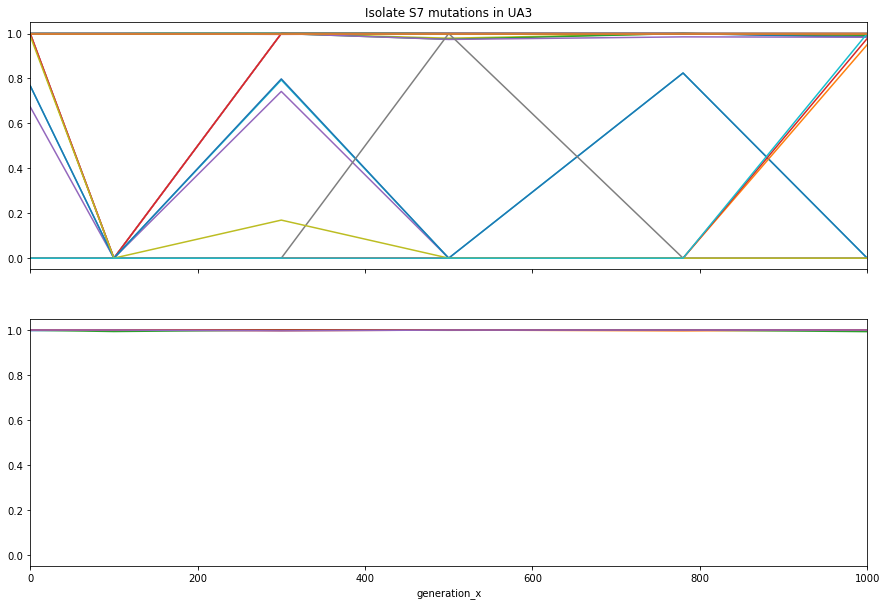

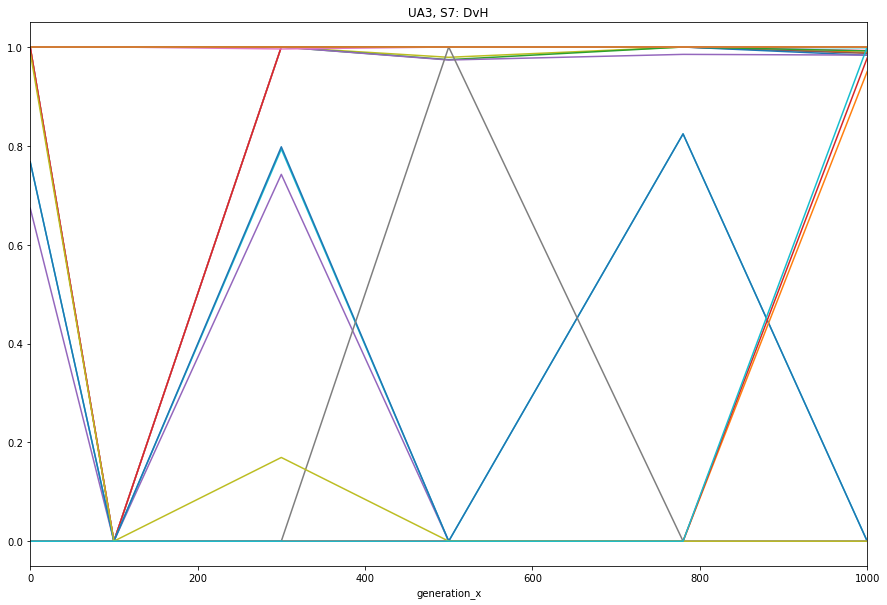

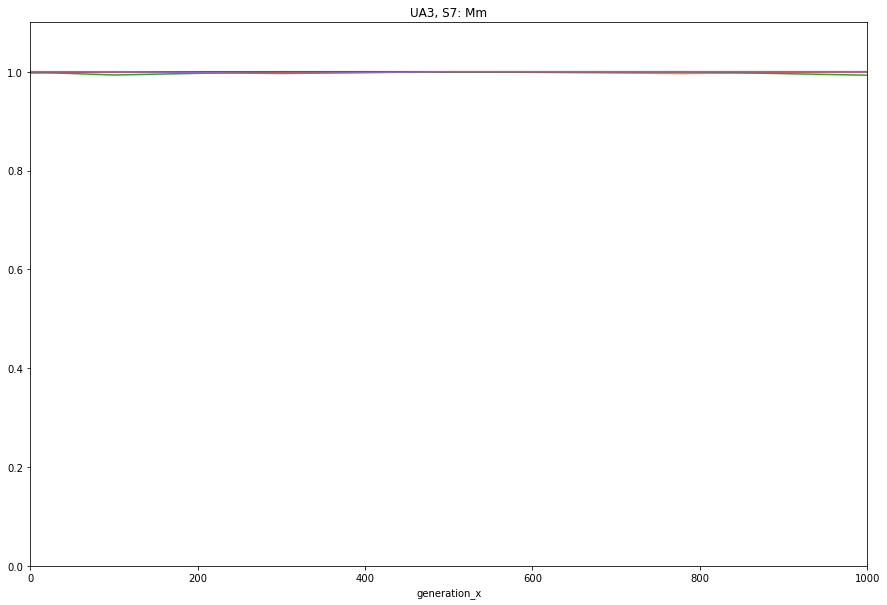

In [7]:
ua3_s7 = get_population_subset_frequencies_to_plot(ua3, s7)

#Figures produced for lab meeting presentation on 11/1/2017

fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(15,10))
ua3_s7['NC_002937'].plot(ax = axes[0], legend=False, title = 'Isolate S7 mutations in UA3') #dvh
ua3_s7['NC_005791'].plot(ax = axes[1], legend=False) #mm
plt.savefig('ua3_s7_dvh_mm.png')

ua3_s7['NC_002937'].plot(legend=False, title = 'UA3, S7: DvH', figsize=(15,10))
plt.savefig('ua3_s7_dvh.png')

ua3_s7['NC_005791'].plot(legend=False, title = 'UA3, S7: Mm', figsize=(15,10), ylim=(0, 1.1))
plt.savefig('ua3_s7_mm.png')

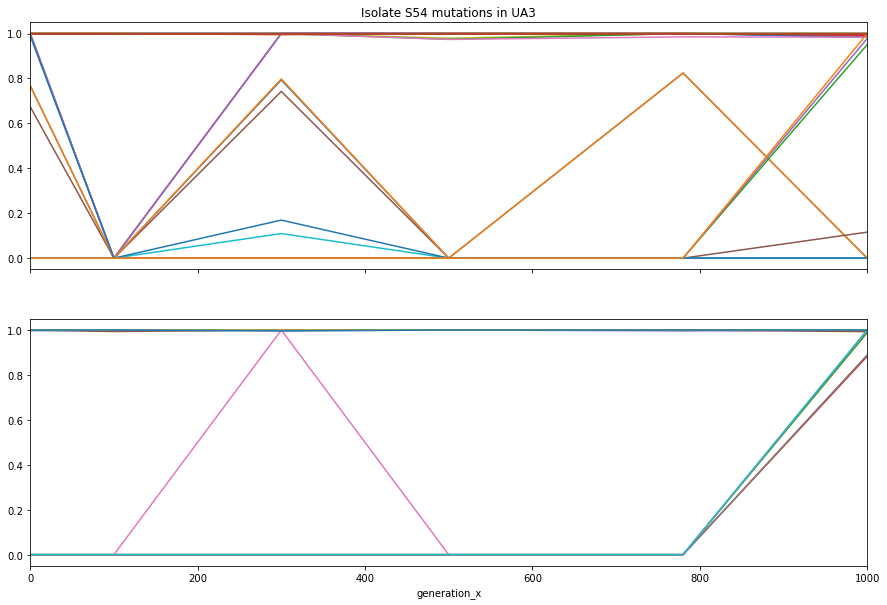

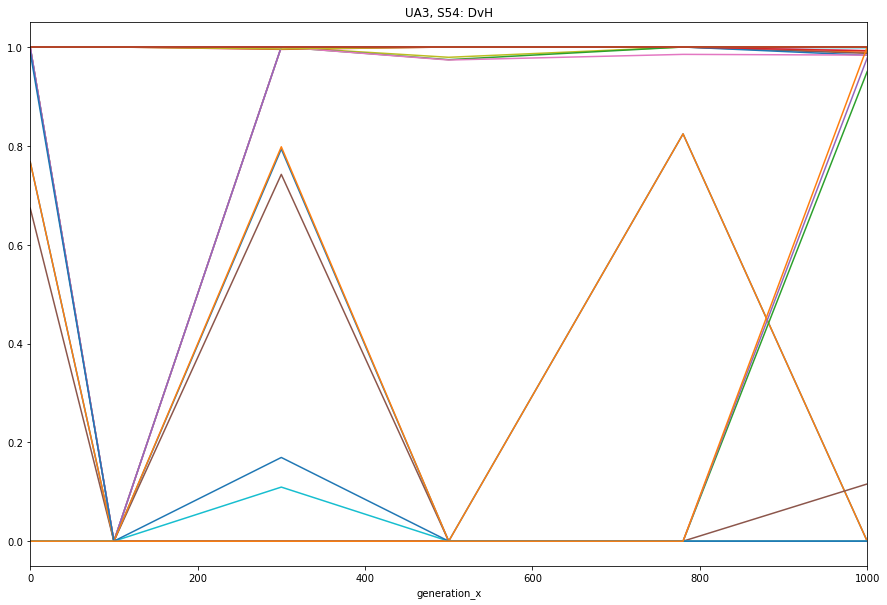

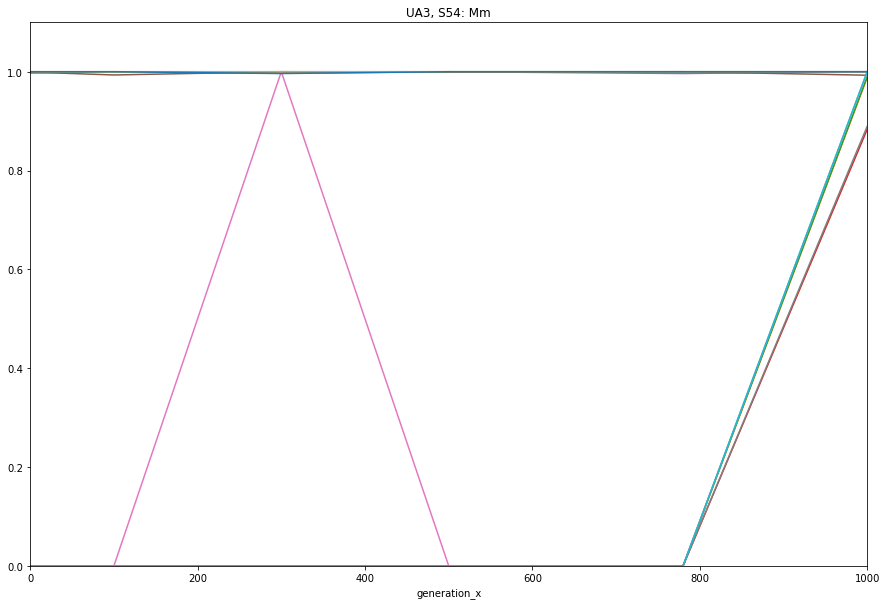

In [8]:
ua3_s54 = get_population_subset_frequencies_to_plot(ua3, s54)

fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(15,10))
ua3_s54['NC_002937'].plot(ax = axes[0], legend=False, title = 'Isolate S54 mutations in UA3') #dvh
ua3_s54['NC_005791'].plot(ax = axes[1], legend=False) #mm
plt.savefig('ua3_s54_dvh_mm.png')

ua3_s54['NC_002937'].plot(legend=False, title = 'UA3, S54: DvH', figsize=(15,10))
plt.savefig('ua3_s54_dvh.png')

ua3_s54['NC_005791'].plot(legend=False, title = 'UA3, S54: Mm', figsize=(15,10), ylim=(0, 1.1))
plt.savefig('ua3_s54_mm.png')

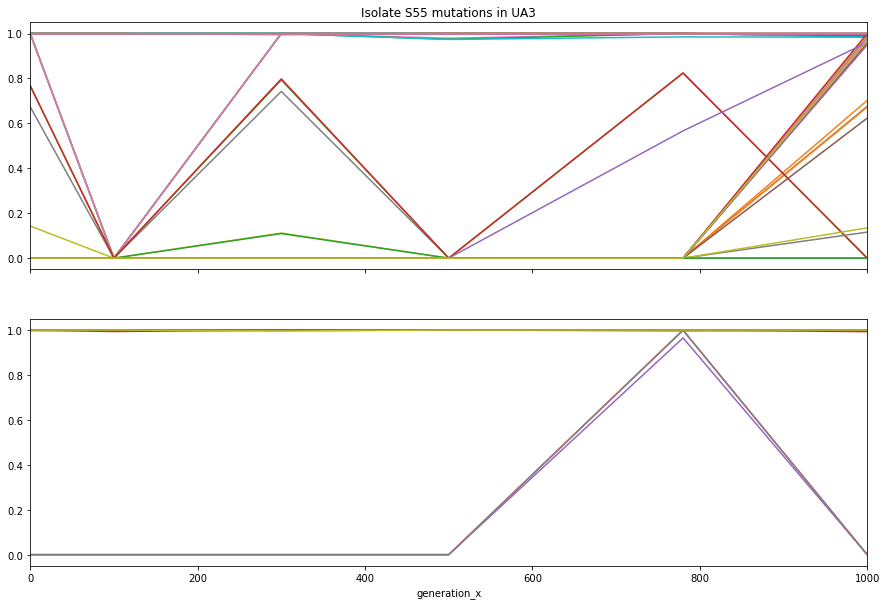

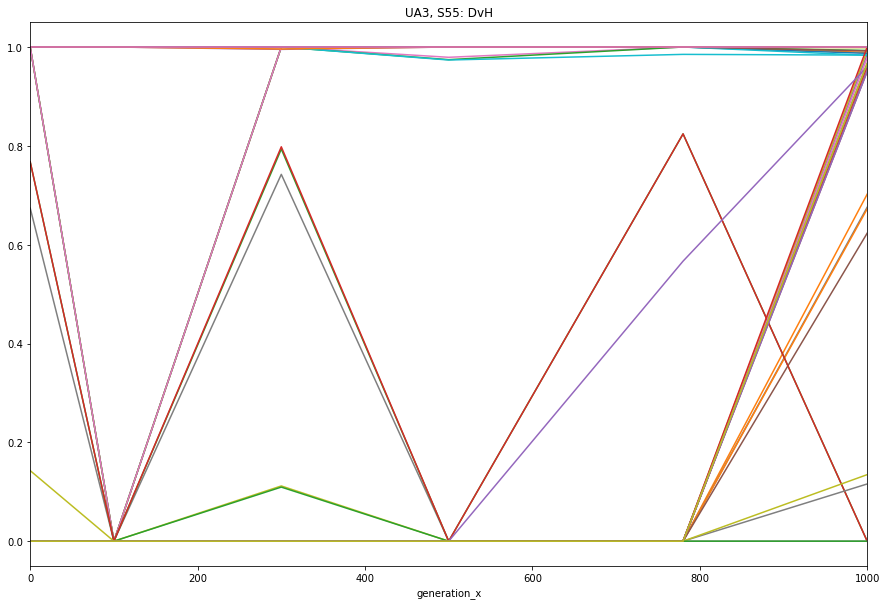

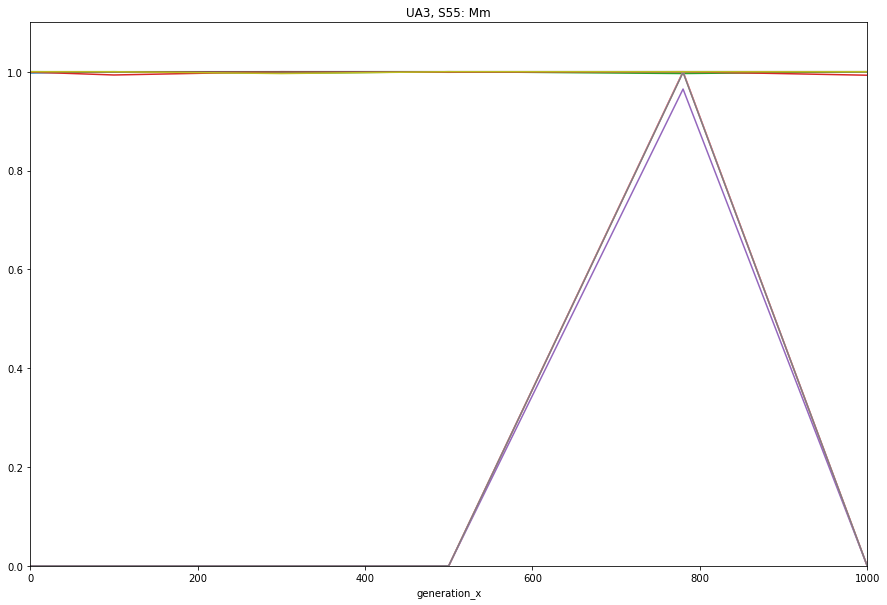

In [9]:
ua3_s55 = get_population_subset_frequencies_to_plot(ua3, s55)

fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(15,10))
ua3_s55['NC_002937'].plot(ax = axes[0], legend=False, title = 'Isolate S55 mutations in UA3') #dvh
ua3_s55['NC_005791'].plot(ax = axes[1], legend=False) #mm
plt.savefig('ua3_s55_dvh_mm.png')

ua3_s55['NC_002937'].plot(legend=False, title = 'UA3, S55: DvH', figsize=(15,10))
plt.savefig('ua3_s55_dvh.png')

ua3_s55['NC_005791'].plot(legend=False, title = 'UA3, S55: Mm', figsize=(15,10), ylim=(0, 1.1))
plt.savefig('ua3_s55_mm.png')

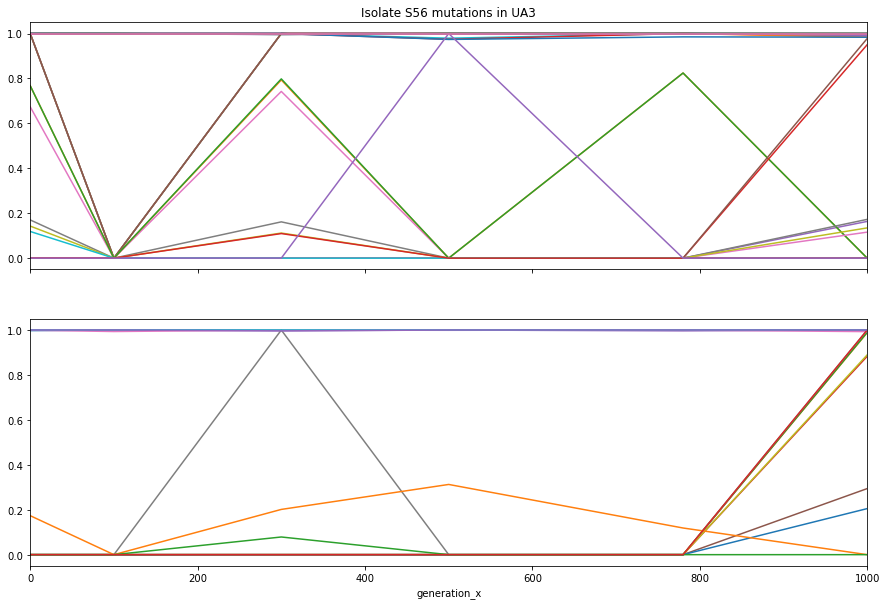

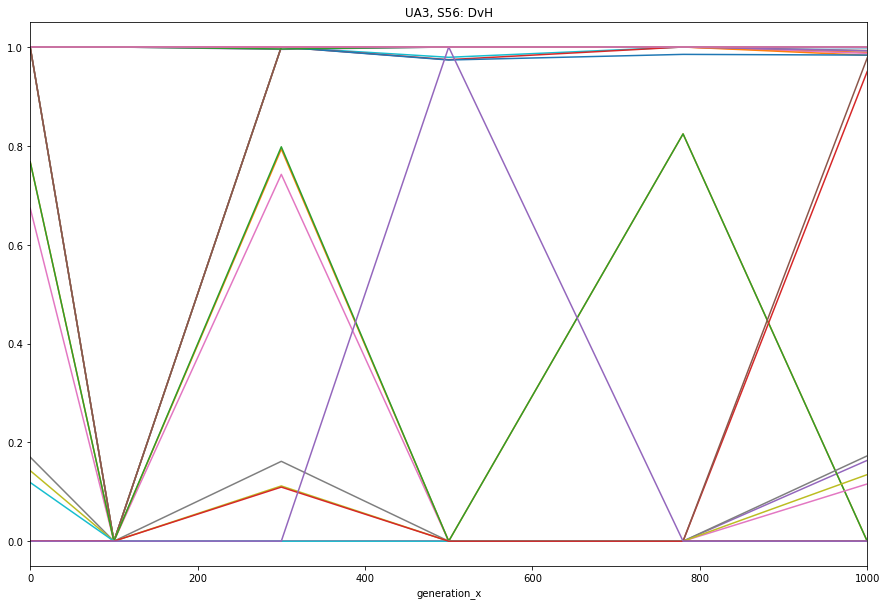

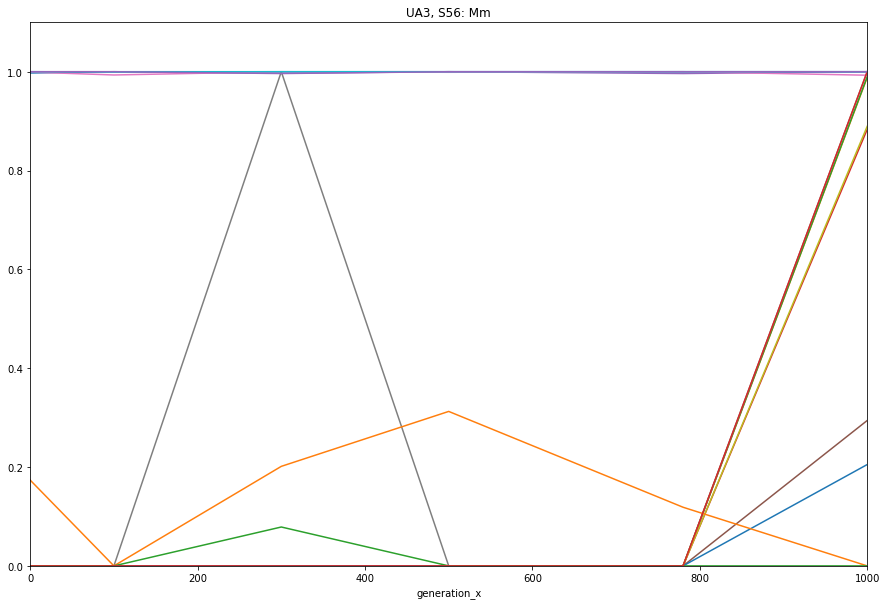

In [10]:
ua3_s56 = get_population_subset_frequencies_to_plot(ua3, s56)

fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(15,10))
ua3_s56['NC_002937'].plot(ax = axes[0], legend=False, title = 'Isolate S56 mutations in UA3') #dvh
ua3_s56['NC_005791'].plot(ax = axes[1], legend=False) #mm
plt.savefig('ua3_s56_dvh_mm.png')

ua3_s56['NC_002937'].plot(legend=False, title = 'UA3, S56: DvH', figsize=(15,10))
plt.savefig('ua3_s56_dvh.png')

ua3_s56['NC_005791'].plot(legend=False, title = 'UA3, S56: Mm', figsize=(15,10), ylim=(0, 1.1))
plt.savefig('ua3_s56_mm.png')

In [13]:
# S7 DvH mutations and affected genes
ua3_gene_mutations = ua3.pivot_table(index=['generation', 'gene_product'], columns=['position', 'entry_type', 'mutation_detail'], values='polymorphism_frequency')
ua3_s7_dvh_mutations = ua3_gene_mutations[ua3_s7['NC_002937'].columns].dropna(axis=0, how='all')
#ua3_s7_dvh_mutations #frequencies are aggregated across generations; ignore for now.

In [14]:
ua3_s7_dvh_mutations.xs('DNA gyrase subunit A', level='gene_product').dropna(axis=1, how='all')
# https://stackoverflow.com/questions/10175068/select-data-at-a-particular-level-from-a-multiindex

position,5565
entry_type,SNP
mutation_detail,A
generation,
0,0.989245
300,0.169407


In [16]:
ua3_s54_dvh_mutations = ua3_gene_mutations[ua3_s54['NC_002937'].columns].dropna(axis=0, how='all')
#ua3_s54_dvh_mutations #frequencies are aggregated across generations; ignore for now.

In [15]:
ua3_s7_mm_mutations = ua3_gene_mutations[ua3_s7['NC_005791'].columns].dropna(axis=0, how='all')
#ua3_s7_mm_mutations #frequencies are aggregated across generations; ignore for now.

In [17]:
ua3_s54_mm_mutations = ua3_gene_mutations[ua3_s54['NC_005791'].columns].dropna(axis=0, how='all')
#ua3_s54_mm_mutations #frequencies are aggregated across generations; ignore for now.

In [18]:
# Is there a core group of mutations that appear in ALL clonal isolates?
# Mutations in common across all 4 isolates, and in population UA3
common_mutations = []
for mutation in ua3_s7.columns.tolist():
    if (mutation in ua3_s54.columns.tolist()) and (mutation in ua3_s55.columns.tolist()) and (mutation in ua3_s56.columns.tolist()):
        common_mutations.append(mutation)
len(common_mutations)

37

In [19]:
common = ua3_mutations[common_mutations].copy()

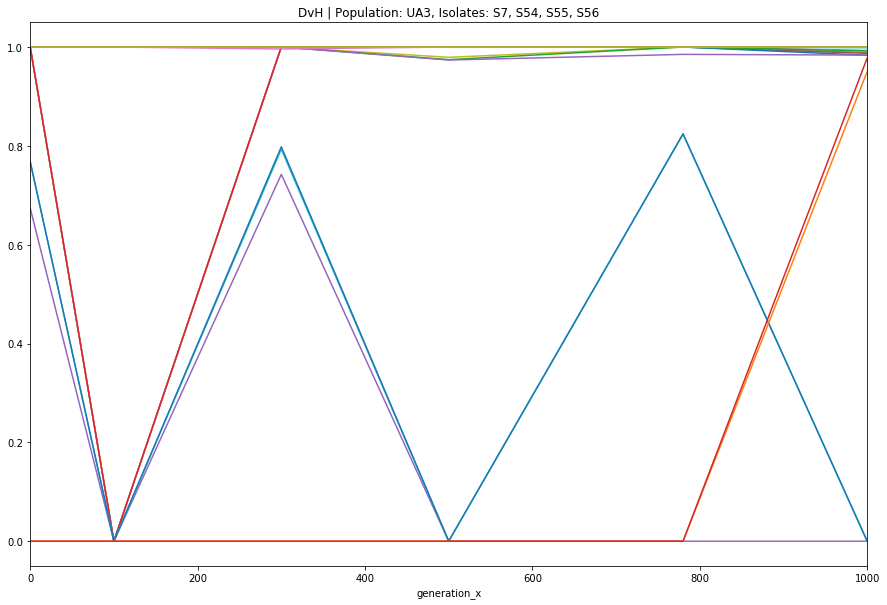

In [24]:
common['NC_002937'].plot(title = 'DvH | Population: UA3, Isolates: S7, S54, S55, S56', figsize=(15, 10), legend=False)
plt.savefig('ua3_s7_s54_s55_s56_dvh.png')

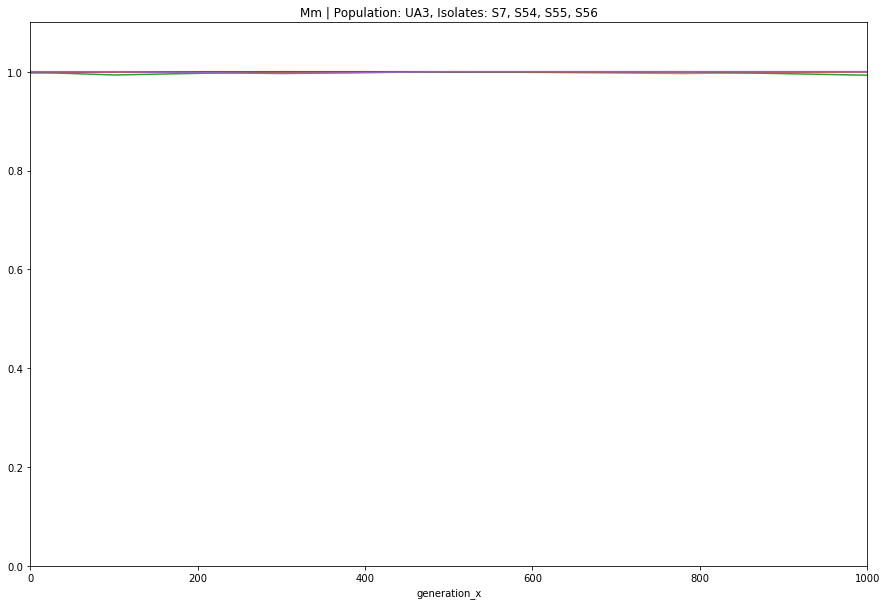

In [25]:
common['NC_005791'].plot(title = 'Mm | Population: UA3, Isolates: S7, S54, S55, S56', ylim=(0, 1.1), figsize=(15, 10), legend=False)
plt.savefig('ua3_s7_s54_s55_s56_mm.png')

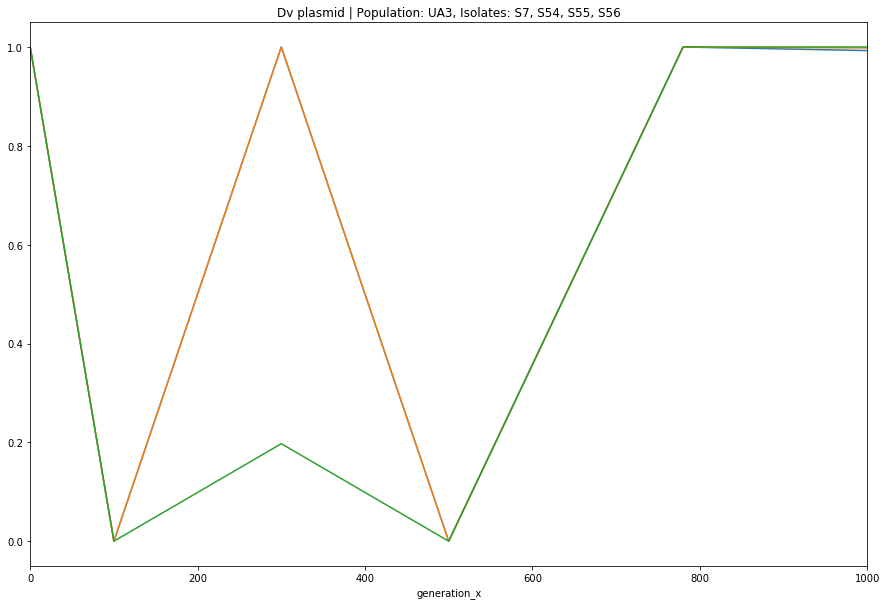

In [26]:
common['NC_005863'].plot(title = 'Dv plasmid | Population: UA3, Isolates: S7, S54, S55, S56', figsize=(15, 10), legend=False)
plt.savefig('ua3_s7_s54_s55_s56_dvplasmid.png')

In [27]:
#DvH mutations in UA3 population
gene_mutations = ua3.pivot_table(index=['genome_id', 'entry_type', 'mutation_detail'], 
                columns='position', values='polymorphism_frequency')
#gene_mutations.loc['NC_002937'].dropna(axis=1, how='all')
# 299 mutations across DvH genomes in UA3 population